In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
import yfinance as yf

In [3]:
start_date = "1980-06-06"
end_date = "2024-06-05"

In [4]:
ticker = "^DJI"

In [5]:
gspc = yf.download(ticker, start=start_date, end=end_date)

[*********************100%%**********************]  1 of 1 completed


In [6]:
gspc = gspc[["Adj Close"]]
gspc = gspc.rename(columns={"Adj Close":"price"})
gspc = gspc.dropna()

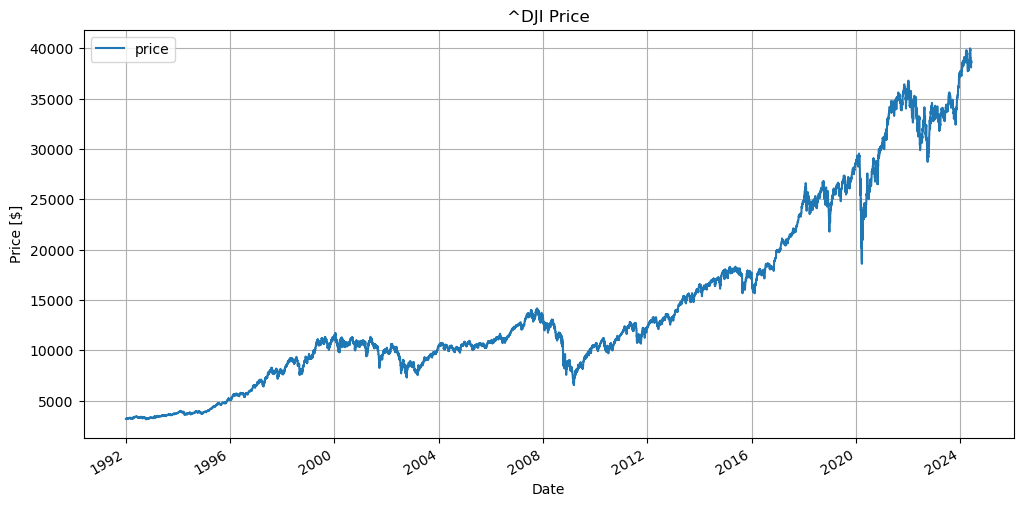

In [7]:
fig, axs = plt.subplots(figsize=(12, 6)) 
gspc.plot(kind="line", ax=axs, grid=True, title=f"{ticker} Price", ylabel="Price [$]")
plt.show()

In [8]:
gspc

,price
Date,
1992-01-02,3172.399902
1992-01-03,3201.500000
1992-01-06,3200.100098
1992-01-07,3204.800049
1992-01-08,3203.899902
...,...
2024-05-29,38441.539062
2024-05-30,38111.480469
2024-05-31,38686.320312


We need to compute lags. What is the shift we have to apply? 1, 2, 5, 10 **financial years** in days

In [9]:
# financial days diff
financial_days_diff = gspc.shape[0]

In [10]:
# real days diff (number of days between end date and start date)
real_days_diff = ((gspc.index[-1] - gspc.index[0]).days + 1)

In [11]:
# financial year length [days]
financial_year_length = int(365* (financial_days_diff / real_days_diff))
financial_year_length

251

## Lags
Compute prices that I had on a day 1, 2, 5, 10 years before

In [12]:
gspc["lag_1y"] = gspc.price.shift(financial_year_length)
gspc["lag_2y"] = gspc.price.shift(2 * financial_year_length)
gspc["lag_5y"] = gspc.price.shift(5 * financial_year_length)
gspc["lag_10y"] = gspc.price.shift(10 * financial_year_length)

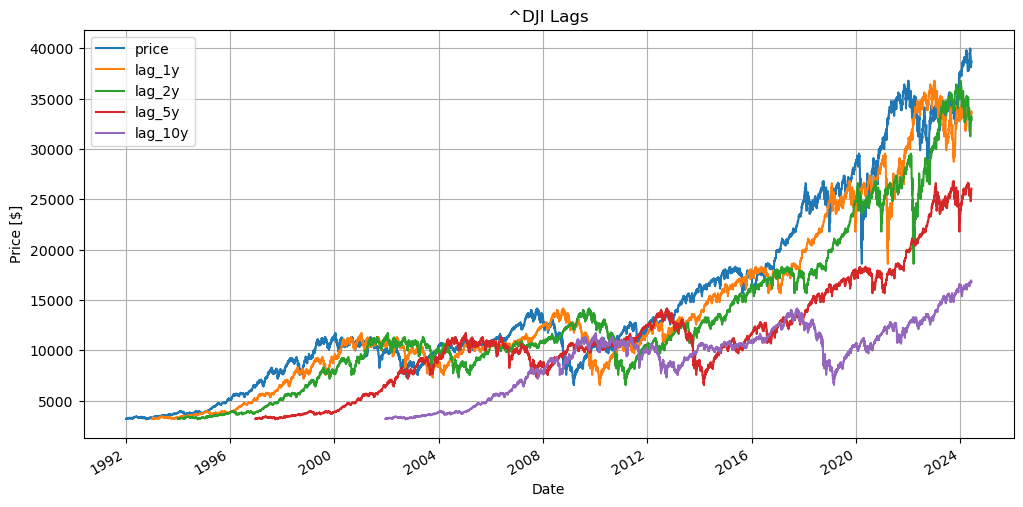

In [13]:
fig, axs = plt.subplots(figsize=(12, 6)) 
gspc.plot(kind="line", ax=axs, grid=True, title=f"{ticker} Lags", ylabel="Price [$]")
plt.show()

## Yearly returns

How much return can I expect to get as **yearly return** if I invest on an asset for 1, 2, 5, 10 years

In [14]:
def compute_yearly_returns(end_price: pd.Series, start_price: pd.Series, lag_length: int) -> pd.Series:
    returns = (end_price - start_price) / start_price 
    adjusted_returns = (returns + 1) ** (1 / lag_length) - 1 
    return adjusted_returns

In [15]:
gspc["yearly_returns_1y"] = compute_yearly_returns(gspc["price"], gspc["lag_1y"], 1)
gspc["yearly_returns_2y"] = compute_yearly_returns(gspc["price"], gspc["lag_2y"], 2)
gspc["yearly_returns_5y"] = compute_yearly_returns(gspc["price"], gspc["lag_5y"], 5)
gspc["yearly_returns_10y"] = compute_yearly_returns(gspc["price"], gspc["lag_10y"], 10)

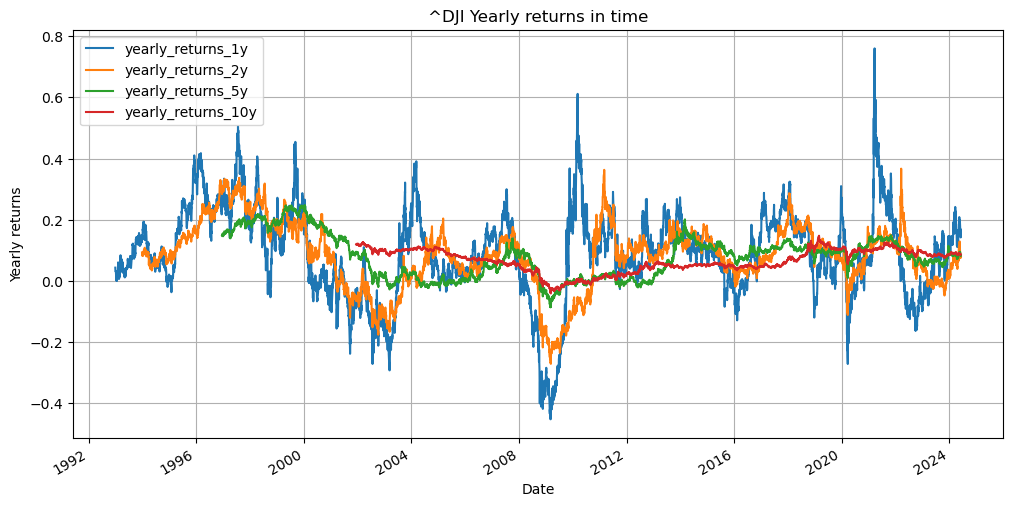

In [16]:
fig, axs = plt.subplots(figsize=(12, 6)) 
gspc.loc[:, "yearly_returns_1y":"yearly_returns_10y"].plot(
    kind="line",
    ax=axs,
    grid=True,
    title=f"{ticker} Yearly returns in time",
    ylabel="Yearly returns"
)
plt.show()

In [17]:
gspc_yearly_returns = gspc.loc[:, "yearly_returns_1y": "yearly_returns_10y"].copy()
gspc_yearly_returns = gspc_yearly_returns.dropna()

In [18]:
gspc_yearly_returns.describe(percentiles=[0.05, 0.25, 0.50, 0.75, 0.95])

,yearly_returns_1y,yearly_returns_2y,yearly_returns_5y,yearly_returns_10y
count,5656.000000,5656.000000,5656.000000,5656.000000
mean,0.068911,0.058810,0.056990,0.065527
std,0.147209,0.097115,0.052726,0.037445
min,-0.452307,-0.270976,-0.085872,-0.040804
5%,-0.195201,-0.143143,-0.016608,-0.006220
25%,0.001897,0.016555,0.006156,0.045332
50%,0.079391,0.073982,0.063988,0.067285
75%,0.158158,0.122889,0.100185,0.099109
95%,0.272355,0.184999,0.136798,0.115946
max,0.760506,0.367244,0.201539,0.147805


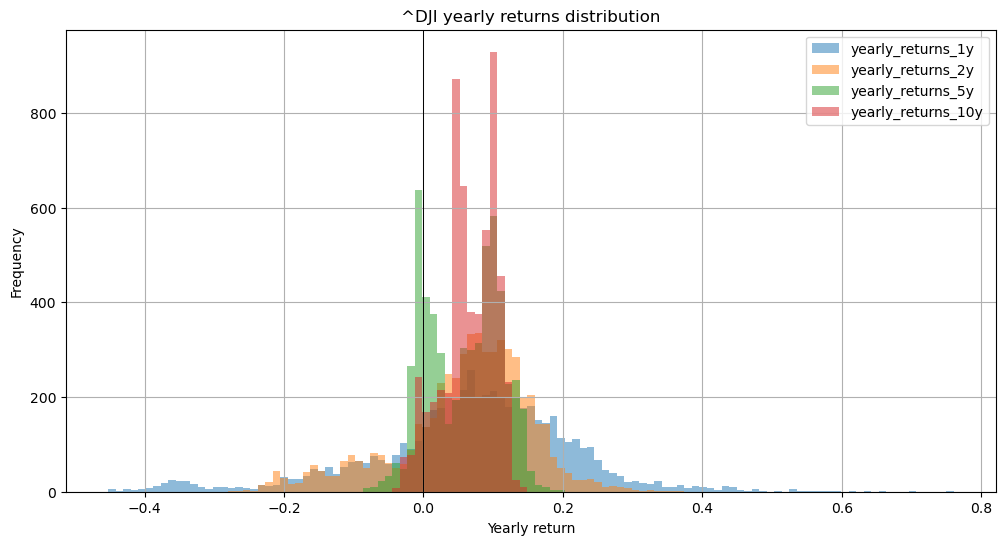

In [19]:
gspc_yearly_returns.plot(
    kind="hist", 
    bins=int(gspc_yearly_returns.shape[0]/ 50), 
    figsize=(12, 6),
    grid=True, 
    xlabel="Yearly return",
    alpha=0.5,
    title=f"{ticker} yearly returns distribution"
)
plt.axvline(0, color="k", linewidth=0.7)
plt.show()

## Compound returns comparison

The compound return after X years of investment is the **cumulative product** of the yearly returns.

In [20]:
# number of simulations 
n_sim = 10000

- For each simulation pick 1, 2, 5, 10 yearly returns
- Compute the cumulative product for each of them
- Plot distribution

In [21]:
# create yearly return simulations
returns_1y_sim = np.random.choice(gspc_yearly_returns["yearly_returns_1y"], size=(n_sim, 1)) + 1
returns_2y_sim = np.random.choice(gspc_yearly_returns["yearly_returns_2y"], size=(n_sim, 2)) + 1
returns_5y_sim = np.random.choice(gspc_yearly_returns["yearly_returns_5y"], size=(n_sim, 5)) + 1
returns_10y_sim = np.random.choice(gspc_yearly_returns["yearly_returns_10y"], size=(n_sim, 10)) + 1

In [22]:
# get compound returns after 1, 2, 5, 10 years
compound_returns_1y = returns_1y_sim.flatten() -1 
compound_returns_2y = (np.cumprod(returns_2y_sim, axis=1) - 1)[:, -1]
compound_returns_5y = (np.cumprod(returns_5y_sim, axis=1) - 1)[:, -1]
compound_returns_10y = (np.cumprod(returns_10y_sim, axis=1) - 1)[:, -1]

In [23]:
compound_returns = np.stack([compound_returns_1y, compound_returns_2y, compound_returns_5y, compound_returns_10y], axis=1)

In [24]:
compound_returns_df = pd.DataFrame(compound_returns * 100, columns=["1 year", "2 years", "5 years", "10 years"])

In [25]:
compound_returns_df

,1 year,2 years,5 years,10 years
0,14.466826,17.804386,51.601186,75.007146
1,7.562565,10.424033,29.658696,62.191740
2,5.406856,28.544907,43.660351,87.670858
3,6.682612,-1.287674,30.605965,91.142157
4,9.028515,36.143236,62.397876,64.483094
...,...,...,...,...
9995,0.730917,-7.310221,17.748035,69.782191
9996,6.265582,-7.812217,24.935090,119.567910
9997,19.827738,21.538613,62.041621,66.503713
9998,13.662697,-1.167266,31.778144,104.905593


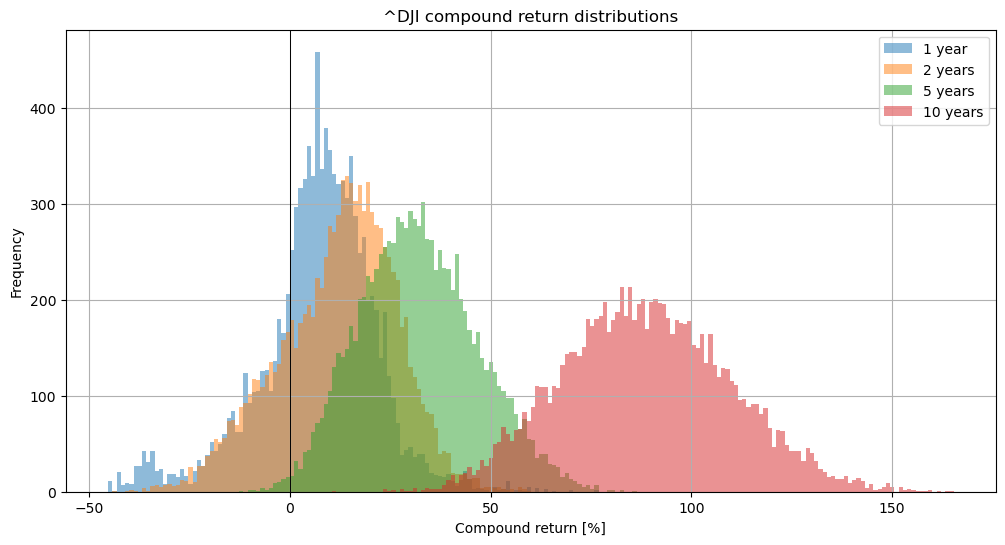

In [26]:
compound_returns_df.plot(
    kind="hist", 
    bins=int(compound_returns_df.shape[0] / 50),
    figsize=(12, 6),
    grid=True, 
    xlabel="Compound return [%]",
    alpha=0.5,
    title=f"{ticker} compound return distributions"
)
plt.axvline(0, color="k", linewidth=0.7)
plt.show()

In [27]:
compound_returns_df.describe(percentiles=[0.05, 0.25, 0.5, 0.75, 0.95])

,1 year,2 years,5 years,10 years
count,10000.000000,10000.000000,10000.000000,10000.000000
mean,6.871747,12.040627,32.154770,88.740752
std,14.758724,14.675350,14.647263,21.007050
min,-45.230677,-43.706628,-11.584618,10.934977
5%,-20.029128,-14.464311,9.224401,54.720317
25%,0.234319,2.652201,21.684543,74.162606
50%,7.929905,13.712615,31.446618,88.217143
75%,15.805516,22.283587,41.942205,102.860935
95%,27.131548,33.787240,57.621317,124.165261
max,76.050576,59.318238,86.370496,165.338299
